<a href="https://colab.research.google.com/github/elsafbyntsss/Natural-Style-Transfer-Tugas-Individu/blob/main/41236698_Elsa_Febiyanti_Natural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Elsa Febiyanti



Kelas : TI 2023 KIP P2



Nim : 41236698

--------------------------------------------------
1. Gambar Konten (Content Image):


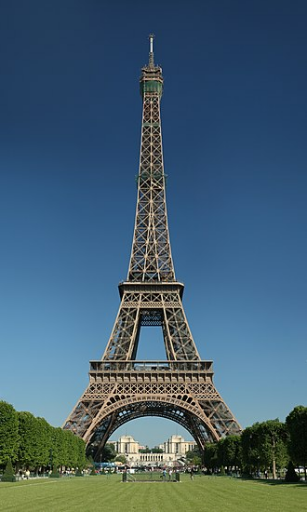


2. Gambar Gaya (Style Image):


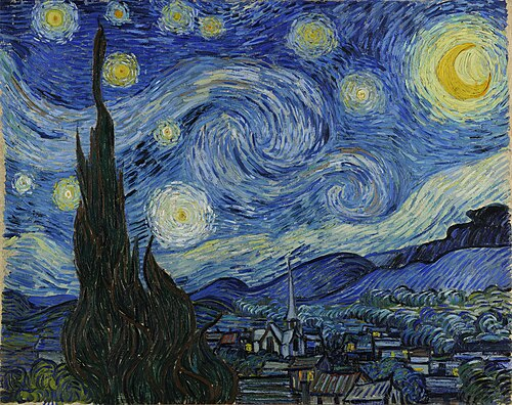

--------------------------------------------------
Memulai proses Style Transfer. Total langkah: 1000...
Proses optimasi selesai dalam 65.15 detik.

3. Hasil Style Transfer (Combined Image):


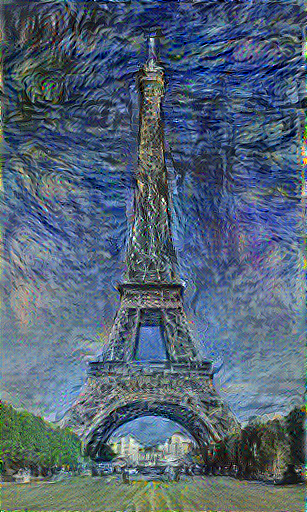


Gambar hasil telah disimpan di Drive Anda sebagai 'hasil_style_transfer.jpg'.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import time
import IPython.display as display
from PIL import Image
import functools

content_path = '/content/drive/MyDrive/deep learning dataset/gambar utama.jpg'
style_path = '/content/drive/MyDrive/deep learning dataset/gambar style.jpg'


def load_img(path_to_img):
    """Memuat gambar dan membatasi dimensi maksimum untuk efisiensi."""
    max_dim = 512

    try:
        img = tf.io.read_file(path_to_img)
    except Exception as e:
        print(f"ERROR: Tidak dapat memuat file di {path_to_img}.")
        print("Pastikan Google Drive sudah di-mount dan path serta nama file sudah benar.")
        raise e

    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    """Mengubah tensor menjadi gambar PIL."""
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


def vgg_layers(layer_names):
    """Memuat model VGG19 yang sudah terlatih dan mengembalikan output dari layer yang diinginkan."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

class StyleContentModel(tf.keras.models.Model):
    """Model yang mengembalikan keluaran konten dan gaya dari input."""
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.norm_means = np.array([103.939, 116.779, 123.68], dtype=np.float32)
        self.norm_means = self.norm_means.reshape((1, 1, 1, 3))
        self.norm_stds = np.array([1, 1, 1], dtype=np.float32)
        self.norm_stds = self.norm_stds.reshape((1, 1, 1, 3))

    def call(self, inputs):
        """Preproses input (gambar), panggil VGG, dan pisahkan keluaran."""
        inputs = inputs *
        preprocessed_input = inputs - self.norm_means
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

def gram_matrix(input_tensor):
    """Menghitung Gram Matrix (korelasi spasial antar fitur)."""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    """Menghitung total loss: Style Loss + Content Loss."""
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    """Satu langkah training menggunakan GradientTape."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

def clip_0_1(image):
    """Memotong nilai piksel agar berada di antara 0 dan 1."""
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    print("--------------------------------------------------")
    print("1. Gambar Konten (Content Image):")
    display.display(tensor_to_image(content_image))
    print("\n2. Gambar Gaya (Style Image):")
    display.display(tensor_to_image(style_image))
    print("--------------------------------------------------")

except Exception as e:
    print("\n--- GAGAL MEMUAT GAMBAR. HENTIKAN EKSEKUSI. ---")
    print("Silakan periksa pesan ERROR di atas.")
else:
    extractor = StyleContentModel(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    image = tf.Variable(content_image)

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    epochs = 10
    steps_per_epoch = 100
    total_steps = epochs * steps_per_epoch

    print(f"Memulai proses Style Transfer. Total langkah: {total_steps}...")

    start = time.time()
    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)

    end = time.time()
    print(f"Proses optimasi selesai dalam {(end - start):.2f} detik.")

    final_image = tensor_to_image(image)
    print("\n3. Hasil Style Transfer (Combined Image):")
    display.display(final_image)

    final_image.save("/content/drive/MyDrive/deep learning dataset/hasil_style_transfer.jpg")
    print("\nGambar hasil telah disimpan di Drive Anda sebagai 'hasil_style_transfer.jpg'.")